# Fetal lung + pan-fetal integration

In [1]:
import os,sys
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import numpy.random as random
import scipy
import anndata
import matplotlib.pyplot as plt

Global seed set to 0


In [2]:
import torch
device = torch.device("cuda")

In [3]:
## import utils
cwd = '/home/jupyter/Pan_fetal_immune/src/utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

## Load datasets

Load fetal lung data

In [4]:
lung_data_file = '/home/jupyter/mount/gdrive/fetal_immune_lung_intergration/220120Annotated_Fetal_lung_immune_filtered_soupxcite.h5ad' 

Download pan-fetal data

In [34]:
!wget https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad

--2022-05-24 10:34:56--  https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 193.62.203.62, 193.62.203.63, 193.62.203.61
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|193.62.203.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3726022388 (3.5G) [application/x-hdf]
Saving to: ‘PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad’

PAN.A01.v01.raw_cou 100%[===================>]   3.47G  65.7MB/s    in 60s     

2022-05-24 10:35:57 (59.2 MB/s) - ‘PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad’ saved [3726022388/3726022388]



In [7]:
adata_lung = sc.read_h5ad(lung_data_file)

In [8]:
adata_lung.var = adata_lung.var.iloc[:,0:2].copy()

In [9]:
adata_panfetal = sc.read_h5ad('./PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad')

In [10]:
adata_panfetal

AnnData object with n_obs × n_vars = 593203 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

## Preprocessing

In [11]:
## Remove CITE-seq proteins
adata_lung = adata_lung[:,~adata_lung.var_names.str.startswith('AB_')].copy()

In [12]:
## Convert lung data back to counts
def CalculateRaw(adata,scaling_factor=10000):
    #update by Polanski in Feb 2022
    #The object must contain a log-transformed matrix
    #This function returns an integer-count object
    #The normalization constant is assumed to be 10000
    #return anndata.AnnData(X=sparse.csr_matrix(np.rint(np.array(np.expm1(adata.X).todense().transpose())*(adata.obs['n_counts'].values).transpose() / scaling_factor).transpose()),\
    #              obs=adata.obs,var=adata.var,obsm=adata.obsm,varm=adata.varm)
    X = np.expm1(adata.X)
    scaling_vector = adata.obs['n_counts'].values / scaling_factor
    #.indptr[i]:.indptr[i+1] provides the .data coordinates where the i'th row of the data resides in CSR
    #which happens to be a cell, which happens to be what we have a unique entry in scaling_vector for
    for i in np.arange(X.shape[0]):
        X.data[X.indptr[i]:X.indptr[i+1]] = X.data[X.indptr[i]:X.indptr[i+1]] * scaling_vector[i]
    return anndata.AnnData(X=np.rint(X),obs=adata.obs,var=adata.var,obsm=adata.obsm,varm=adata.varm)

adata_lung.X = scipy.sparse.csr_matrix(adata_lung.X)
adata_lung = CalculateRaw(adata_lung)

In [13]:
## Convert gene names to EnsemblIDs
adata_lung.var['gene_names'] = adata_lung.var_names.copy()
adata_lung.var_names = adata_lung.var['gene_ids-Gurdon'].copy()
adata_lung.var_names = adata_lung.var_names.astype("str")

/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ENSG00000121410', 'ENSG00000268895', 'ENSG00000148584', 'ENSG00000175899', 'ENSG00000245105']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [14]:
## Use GeneIDs from pan-fetal for missing genes
missing_ids_ixs = adata_lung.var_names == 'nan'
missing_ids = adata_lung.var[missing_ids_ixs]['gene_names']
adata_lung.var_names.values[missing_ids_ixs] = adata_panfetal.var['GeneID'].loc[missing_ids].values

## scVI integration _de novo_

I opted for _de novo_ rather than using saved model and scArches because > 10% of genes used for original pan-fetal embedding were missing from the fetal lung dataset.

In [63]:
scvi.model.SCVI.setup_anndata(adata, layer='counts', categorical_covariate_keys = ["method", 'donor'])

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 670749 cells, 7500 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [ ]:
arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae = scvi.model.SCVI(adata, n_latent=20, **arches_params)
vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=400, 
        batch_size=1024, 
        limit_train_batches=20
       )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 99/400:  25%|██▍       | 99/400 [04:32<13:55,  2.77s/it, loss=1.37e+03, v_num=1]

In [ ]:
## Save embedding
x_scvi = vae.get_latent_representation()
np.save("/home/jupyter/mount/gdrive/fetal_immune_lung_intergration/Lung_panfetal_merged.scVI_out.V3.npy", x_scvi)

In [ ]:
concat_adata.obsm['X_scvi'] = x_scvi.copy()

In [ ]:
sc.pl.embedding(concat_adata, 'X_scvi', color='dataset', components=['1,2', '3,4', '5,6'], size=5)

In [ ]:
## Compute UMAP
sc.pp.neighbors(concat_adata, n_neighbors=50, use_rep="X_scvi")
sc.tl.umap(concat_adata, min_dist = 0.01, spread = 2)

In [ ]:
np.save("/home/jupyter/mount/gdrive/fetal_immune_lung_intergration/Lung_panfetal_merged.scVI_out.V3.UMAP.npy", concat_adata.obsm['X_umap'])

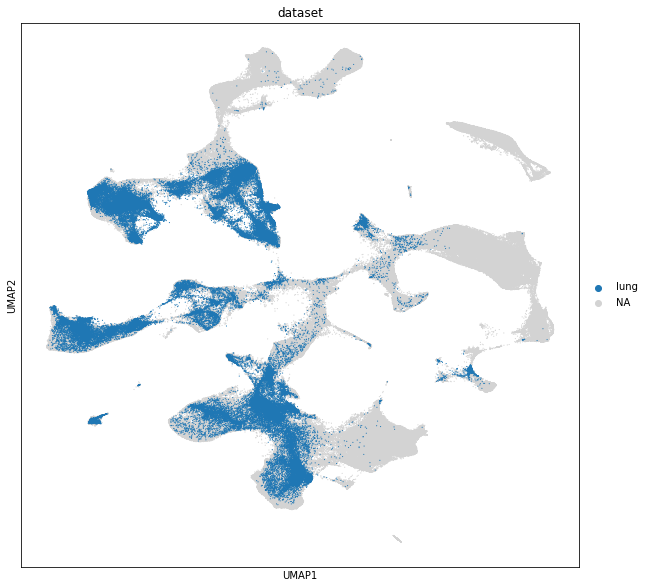

In [73]:
plt.rcParams['figure.figsize'] = [10,10]
sc.pl.umap(concat_adata, color='dataset', groups='lung', size=5)

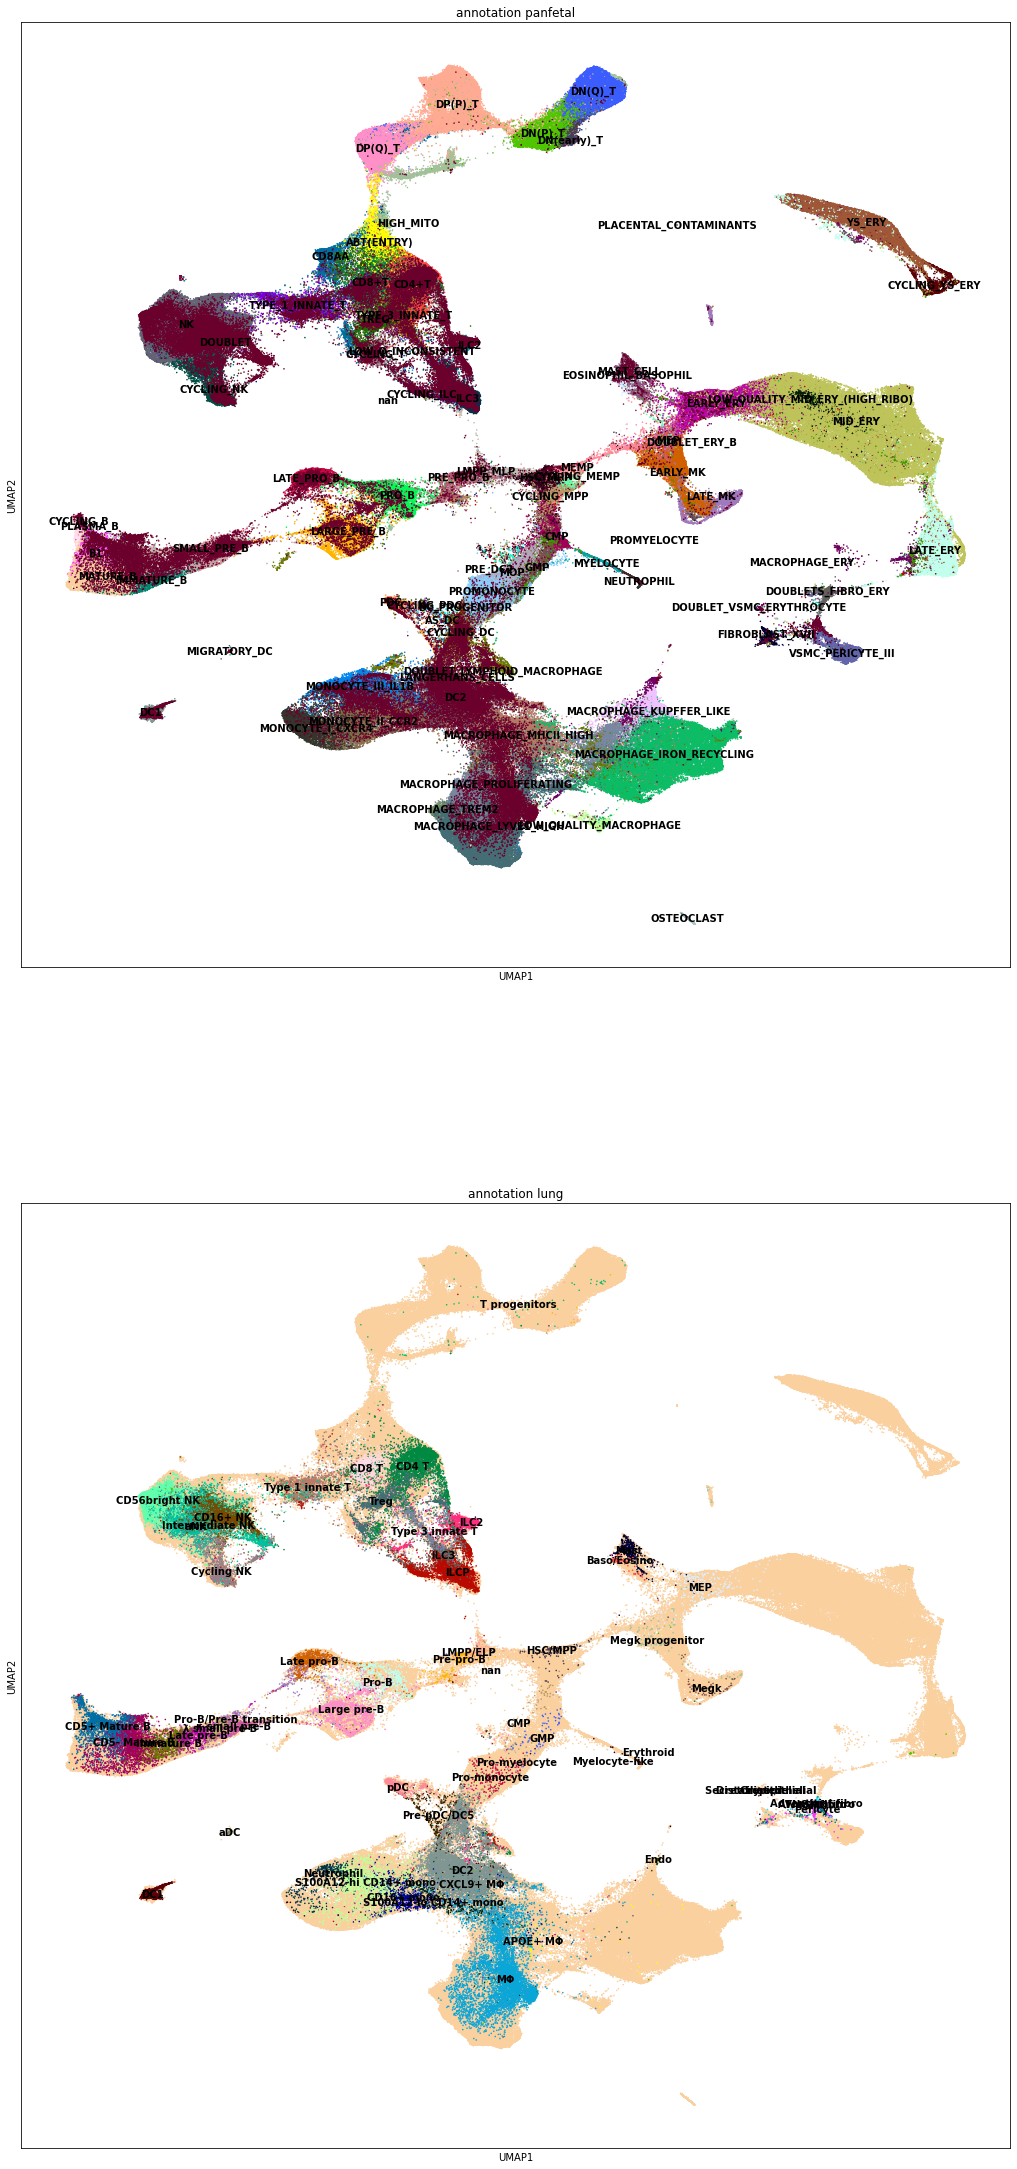

In [74]:
plt.rcParams['figure.figsize'] = [18,18]
sc.pl.umap(concat_adata, color=['celltype_annotation','celltype'], 
           size=10, 
           title=['annotation panfetal', 'annotation lung'], legend_loc='on data', ncols=1)

In [77]:
for i,t in enumerate(concat_adata.obs.dtypes):
    concat_adata.obs.iloc[:,i] = concat_adata.obs.iloc[:,i].astype('str')

concat_adata.var = concat_adata.var[['GeneName', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var']]
concat_adata.write_h5ad('/home/jupyter/mount/gdrive/fetal_immune_lung_intergration/Lung_panfetal_merged.scVI.V3.h5ad')

/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'n_counts' as categorical
/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'n_genes' as categorical
/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories wil

In [84]:
del concat_adata.layers['counts']

In [89]:
for obsm in ['X_bbknn_umap', 'X_pca', 'X_umap_original']:
    del concat_adata.obsm[obsm]

In [92]:
concat_adata

AnnData object with n_obs × n_vars = 670749 × 25076
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'batch', 'status', 'assignment', 'stage', 'percent_mito', 'bh_pval', 'leiden', 'phase', 'S_score', 'G2M_score', 'project', 'domain', 'gender', 'leiden_R', 'celltype', 'status_summary', 'productive_summary', 'isotype_summary', 'receptor_type', 'receptor_subtype', 'temp', 'dataset'
    var: 'GeneName', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap', 'log1p', 'hvg', 'dataset_colors', 'neighbors', 'celltype_annotation_colors', 'celltype_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'distances', 'connectivities'

In [93]:
concat_adata.write_h5ad('/home/jupyter/mount/gdrive/fetal_immune_lung_intergration/Lung_panfetal_merged.scVI.V3.small.h5ad')